# Introduction to PostGIS in CyberGISX - Demo

Weiye Chen, weiyec2@illinois.edu

PostGIS is an extension to the PostgreSQL object-relational database system which allows GIS (Geographic Information Systems) objects to be stored in the database. PostGIS includes support for GiST-based R-Tree spatial indexes, and functions for analysis and processing of GIS objects. 

Resources for PostGIS:
* Manual https://postgis.net/docs/

In this demo, we use PostGIS 3.0. Note that significant changes in APIs have been made to PostGIS compared to version 2.x. This demo assumes that you have basic knowledge of SQL. 

## 0. Configuration of Databases

Assuming we have configured the PostgreSQL database, we need to connect to the hosting PostgreSQL Server. To do that, we will use the IPython extension of SQL, and we will load the extension with the Jupyter magic command: 

In [1]:
%reload_ext sql

In [2]:
%sql postgresql://localhost:5432/postgisdemo

'Connected: @postgisdemo'

Creating `postgis` extension for the database. `postgis` is usually an embeded extension in PostgreSQL databases, and it's already preinstalled in the CyberGISX environment. To enable the extension in the newly created database schema, we need to initialize the extension by loading it. A common way to load extension in PostgreSQL is to use `create extension [ext]` command. 

In [3]:
%%sql 
drop extension if exists postgis cascade;
create extension postgis;

 * postgresql://localhost:5432/postgisdemo
Done.
Done.


[]

The connection to the PostgreSQL databases and initialization of the PostGIS extension are all set now. 

## 1. GIS Objects in PostGIS

The GIS objects supported by PostGIS are a superset of the "Simple Features" defined by the OpenGIS Consortium (OGC). PostGIS supports all the objects and functions specified in the OGC "Simple Features for SQL" specification.

The OpenGIS specification defines two standard ways of expressing spatial objects: the Well-Known Text (WKT) form and the Well-Known Binary (WKB) form. Both WKT and WKB include information about the type of the object and the coordinates which form the object.

Examples of the text representations (WKT) of the spatial objects of the features are as follows:

* `POINT(0 0)`

* `LINESTRING(0 0,1 1,1 2)`

* `POLYGON((0 0,4 0,4 4,0 4,0 0),(1 1, 2 1, 2 2, 1 2,1 1))`

* `MULTIPOINT((0 0),(1 2))`

* `MULTILINESTRING((0 0,1 1,1 2),(2 3,3 2,5 4))`

* `MULTIPOLYGON(((0 0,4 0,4 4,0 4,0 0),(1 1,2 1,2 2,1 2,1 1)), ((-1 -1,-1 -2,-2 -2,-2 -1,-1 -1)))`

* `GEOMETRYCOLLECTION(POINT(2 3),LINESTRING(2 3,3 4))`

### 1.1 Creation of GIS Objects in PostGIS
We could generate those objects with PostGIS functions:

Generating a Point with [`ST_Point`](https://postgis.net/docs/ST_Point.html): (`ST_AsText` would convert the geometries to well-known text)

In [4]:
%sql SELECT ST_AsText(ST_Point(0, 0))

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


st_astext
POINT(0 0)


Make a LineString with [`ST_MakeLine`](https://postgis.net/docs/ST_MakeLine.html):

In [5]:
%sql SELECT ST_AsText(ST_MakeLine(ARRAY[ST_Point(0, 0), ST_Point(1, 1), ST_Point(1, 2)]))

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


st_astext
"LINESTRING(0 0,1 1,1 2)"


Or just use WKT to make a line:

In [6]:
%sql SELECT ST_AsText(ST_LineFromText('LINESTRING(0 0,1 1,1 2)'))

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


st_astext
"LINESTRING(0 0,1 1,1 2)"


To construct a polygon, we could use [`ST_Polygon`](https://postgis.net/docs/ST_Polygon.html)

In [7]:
%sql SELECT ST_AsText(ST_Polygon('LINESTRING(75 29, 77 29, 77 29, 75 29)'::geometry, 4326) );

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


st_astext
"POLYGON((75 29,77 29,77 29,75 29))"


[`ST_GeomFromText`](https://postgis.net/docs/ST_GeomFromText.html) provides a good way to construct any geometry from WKT

In [8]:
%sql SELECT ST_AsText(ST_GeomFromText('MULTIPOLYGON(((0 0,4 0,4 4,0 4,0 0),(1 1,2 1,2 2,1 2,1 1)), ((-1 -1,-1 -2,-2 -2,-2 -1,-1 -1)))'))

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


st_astext
"MULTIPOLYGON(((0 0,4 0,4 4,0 4,0 0),(1 1,2 1,2 2,1 2,1 1)),((-1 -1,-1 -2,-2 -2,-2 -1,-1 -1)))"


To make a geometry collection or a multi-geometry, like multi-point, we may use [`ST_Collect`](https://postgis.net/docs/ST_Collect.html).

In [9]:
%sql SELECT ST_AsText(ST_Collect(ARRAY[ST_Point(0, 0), ST_Point(1, 1), ST_Point(1, 2)]))

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


st_astext
"MULTIPOINT(0 0,1 1,1 2)"


### 1.2 Get GIS Objects into Databases

In the previous database we created with `postgis` extension, we can create a table for our GIS object. The `postgis` extension create a new data type in PostgreSQL named `geometry`. In fact, a lot of aforementioned functions return objects of type `geometry` (e.g. `ST_Point`, `ST_MakeLine`).

Now we want to create a table which contains a attribute of `geometry` type. With `%%sql` cell magic of Jupyter Notebook, we can write SQL scripts without having to have `%sql` command in front of every SQL command. The table creation follows the PostgreSQL standard.

In [10]:
%%sql
drop table if exists gis_example;

create table gis_example(
    id serial primary key,
    geom geometry
);

 * postgresql://localhost:5432/postgisdemo
Done.
Done.


[]

Insert a point to the newly created table `gis_example`. 

In [11]:
%%sql
insert into gis_example(geom) values (ST_Point(0, 1));
select ST_AsText(geom) as geom from gis_example;

 * postgresql://localhost:5432/postgisdemo
1 rows affected.
1 rows affected.


geom
POINT(0 1)


We can insert multiple entries into the table at the same time. 

In [12]:
%%sql
insert into gis_example(geom) values
    (ST_MakeLine(ARRAY[ST_Point(0, 0), ST_Point(1, 1), ST_Point(1, 2)])),
    (ST_MakePolygon('LINESTRING(75 29, 77 29, 77 29, 75 29)'::geometry))
;
select ST_AsText(geom) as geom from gis_example;

 * postgresql://localhost:5432/postgisdemo
2 rows affected.
3 rows affected.


geom
POINT(0 1)
"LINESTRING(0 0,1 1,1 2)"
"POLYGON((75 29,77 29,77 29,75 29))"


## 2. Import Vector GIS Data to PostGIS

In this section, we will give some examples of loading shapefiles to the PostgreSQL database with PostGIS and GeoPandas. 

We have preprocessed the OpenStreetMap data within the extent of University of Illinois, Urbana-Champaign, and saved them as shapefiles. We will use these data for this demo. 

In [13]:
from geopandas import gpd, GeoDataFrame, read_file

### 2.1 Import point based data

In [14]:
data_path = "UIUC_osm"
uiuc_pts = read_file(data_path + "/UIUC_pts.shp")
uiuc_pts.head()

,name,highway,geometry
0,None,stop,POINT (-88.20886 40.10922)
1,None,traffic_signals,POINT (-88.21927 40.10907)
2,None,traffic_signals,POINT (-88.23040 40.11029)
3,None,traffic_signals,POINT (-88.23026 40.10415)
4,None,traffic_signals,POINT (-88.22397 40.11278)


Now we want to dump the geopandas data frame to a csv file so that we could use PostgreSQL to read the table. 

In [15]:
uiuc_pts.to_csv("UIUC_osm/UIUC_pts.csv", index = False)

In [16]:
data_path = !pwd UIUC_osm/UIUC_pts.csv
data_path = data_path[0] + "/" + "UIUC_osm/UIUC_pts.csv"
data_path

'/Users/weiye/Codings/2020/CyberGIS-Jupyter/PostGIS_Intro/UIUC_osm/UIUC_pts.csv'

Now that a csv file is created, we want to create a table in the database to store the points of interest in the UIUC.

In [17]:
%%sql
drop table if exists uiuc_pts;
create table uiuc_pts(
    id serial primary key,
    name text,
    type text,
    geom_text text,
    geom geometry(Point, 4326),
    geog geography
);

 * postgresql://localhost:5432/postgisdemo
Done.
Done.


[]

In [18]:
query = """
copy uiuc_pts(name, type, geom_text)
from '{}' delimiter ',' csv header;
""".format(data_path)

%sql $query

 * postgresql://localhost:5432/postgisdemo
1495 rows affected.


[]

In [19]:
%%sql
UPDATE uiuc_pts
SET geom = ST_SetSRID(ST_GeomFromText(geom_text), 4326),
    geog = geom::geography;

ALTER TABLE uiuc_pts
DROP geom_text;

 * postgresql://localhost:5432/postgisdemo
1495 rows affected.
Done.


[]

In [20]:
%%sql
DELETE from uiuc_pts where name is null;

 * postgresql://localhost:5432/postgisdemo
1201 rows affected.


[]

In [21]:
%sql SELECT name, ST_AsText(geom) from uiuc_pts LIMIT 10

 * postgresql://localhost:5432/postgisdemo
10 rows affected.


name,st_astext
Mile 1,POINT(-88.2386997 40.1090201)
WPGU-FM (Urbana),POINT(-88.2325805 40.110428)
La Casa Cultural Latina,POINT(-88.23116 40.1072538)
Wardall Hall,POINT(-88.2217719 40.109536)
Townsend Hall,POINT(-88.2206535 40.1098519)
Beckwith Hall,POINT(-88.2366958 40.1087613)
Krannert Art Museum,POINT(-88.2314378 40.101976)
University of Illinois College of Law,POINT(-88.2315062 40.1010097)
Alma Mater,POINT(-88.2283814 40.1099142)
Caffe Paradiso,POINT(-88.2194361 40.1057621)


### 2.2 Import Bus Route (LineStrings)

In [22]:
%%sql
drop table if exists uiuc_bus;
create table uiuc_bus(
    id serial primary key,
    name text,
    geom_text text,
    geom geometry(MultiLineString,4326),
    geog geography
);

 * postgresql://localhost:5432/postgisdemo
Done.
Done.


[]

In [23]:
data_path = "UIUC_osm"
uiuc_plgs = read_file(data_path + "/UIUC_Bus.shp")
uiuc_plgs = uiuc_plgs[['name', 'geometry']]
uiuc_plgs.tail()

,name,geometry
22,MTD 5E Green Express Weekday,"MULTILINESTRING ((-88.23336 40.10053, -88.2332..."
23,MTD 12W Teal Weekday - Daytime,"MULTILINESTRING ((-88.22285 40.10061, -88.2228..."
24,MTD 13S Silver Weekday - Daytime,"MULTILINESTRING ((-88.20952 40.11242, -88.2099..."
25,MTD 21 Raven Weekday - Daytime,"MULTILINESTRING ((-88.23022 40.10148, -88.2302..."
26,MTD 22S Illini Weekday - Daytime,"MULTILINESTRING ((-88.22397 40.11278, -88.2239..."


In [24]:
uiuc_plgs.to_csv("UIUC_osm/UIUC_Bus.csv", index = False)
data_path = !pwd UIUC_osm/UIUC_Bus.csv
data_path = data_path[0] + "/" + "UIUC_osm/UIUC_Bus.csv"
data_path

'/Users/weiye/Codings/2020/CyberGIS-Jupyter/PostGIS_Intro/UIUC_osm/UIUC_Bus.csv'

In [25]:
query = """
copy uiuc_bus(name, geom_text)
from '{}' delimiter ',' csv header;
""".format(data_path)

%sql $query

 * postgresql://localhost:5432/postgisdemo
27 rows affected.


[]

In [26]:
%sql DELETE from uiuc_bus where name not like 'MTD%'

 * postgresql://localhost:5432/postgisdemo
2 rows affected.


[]

In [27]:
%%sql
UPDATE uiuc_bus
SET geom = ST_SetSRID(ST_GeomFromText(geom_text), 4326),
    geog = geom::geography;

ALTER TABLE uiuc_bus
DROP geom_text;

 * postgresql://localhost:5432/postgisdemo
25 rows affected.
Done.


[]

In [28]:
%%sql
SELECT name from uiuc_bus order by name asc

 * postgresql://localhost:5432/postgisdemo
25 rows affected.


name
MTD 10E Gold Weekday - Daytime
MTD 10W Gold Weekday - Daytime
MTD 12E Teal Weekday - Daytime
MTD 12W Teal Weekday - Daytime
MTD 13N Silver Weekday - Daytime
MTD 13S Silver Weekday - Daytime
MTD 1N Yellow Weekday - Day
MTD 1S Yellow Weekday - Day
MTD 21 Raven Weekday - Daytime
MTD 22N Illini Weekday - Daytime


### 2.3 Import Polygon Data

In [29]:
%%sql
drop table if exists uiuc_plg;
create table uiuc_plg(
    id serial primary key,
    name text,
    type text,
    geom_text text,
    geom geometry(geometry,4326),
    geog geography
);

 * postgresql://localhost:5432/postgisdemo
Done.
Done.


[]

In [30]:
data_path = "UIUC_osm"
uiuc_plgs = read_file(data_path + "/UIUC_polygons.shp")
uiuc_plgs = uiuc_plgs[['name', 'amenity','geometry']]
uiuc_plgs.head()

,name,amenity,geometry
0,Main Library,library,"POLYGON ((-88.22827 40.10513, -88.22827 40.104..."
1,Weston Hall,None,"POLYGON ((-88.23568 40.10319, -88.23493 40.103..."
2,TIS College Bookstore,None,"POLYGON ((-88.23100 40.10989, -88.23053 40.109..."
3,Illinois Street Residence Halls,None,"POLYGON ((-88.22144 40.10949, -88.22144 40.109..."
4,Allen Hall,None,"POLYGON ((-88.22057 40.10464, -88.22057 40.104..."


In [31]:
uiuc_plgs.to_csv("UIUC_osm/UIUC_plgs.csv", index = False)
data_path = !pwd UIUC_osm/UIUC_plgs.csv
data_path = data_path[0] + "/" + "UIUC_osm/UIUC_plgs.csv"
data_path

'/Users/weiye/Codings/2020/CyberGIS-Jupyter/PostGIS_Intro/UIUC_osm/UIUC_plgs.csv'

In [32]:
query = """
copy uiuc_plg(name, type, geom_text)
from '{}' delimiter ',' csv header;
""".format(data_path)

%sql $query

 * postgresql://localhost:5432/postgisdemo
930 rows affected.


[]

In [33]:
%%sql
UPDATE uiuc_plg
SET geom = ST_SetSRID(ST_GeomFromText(geom_text), 4326),
    geog = geom::geography;

ALTER TABLE uiuc_plg
DROP geom_text;

 * postgresql://localhost:5432/postgisdemo
930 rows affected.
Done.


[]

In [34]:
%%sql
SELECT name, type from uiuc_plg where name <> '' and type <> '' limit 10

 * postgresql://localhost:5432/postgisdemo
10 rows affected.


name,type
Main Library,library
ACES Library,library
Episcopal Church,place_of_worship
Art Annex Studio 2,arts_centre
University High School grounds,school
University of Illinois at Urbana-Champaign,university
Foellinger Auditorium,theatre
McKinley Health Center,hospital
E15,parking
E12,parking


## 3. Spatial Operations

In this section, we will explore the frequently used spatial operation that PostGIS enables us to do. We may use either the data we have imported to the PostgreSQL database or some arbitary shapes. 

### 3.1 Geometry Accessors

Get the geometric type of a geometry object. The keyword `DISTINCT` will return the unique values of the query results (resolving duplicates).

In [35]:
%sql select distinct ST_GeometryType(geom) from uiuc_plg

 * postgresql://localhost:5432/postgisdemo
2 rows affected.


st_geometrytype
ST_MultiPolygon
ST_Polygon


Querying the dimension of the geometry

In [36]:
%sql select ST_Dimension(geom) from uiuc_plg limit 1

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


st_dimension
2


Get the number of vertices of a geometry. The following command gets the number of features with more than 10 vertices. 

In [37]:
%sql select count(name) from uiuc_plg where ST_NPoints(geom) > 10

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


count
164


Retrieve the SRID of a geometry. SRID is an integer value that uniquely identifies the Spatial Referencing System (SRS) within the database. Read more about SRID and Spatial references in this [link](https://postgis.net/docs/using_postgis_dbmanagement.html#spatial_ref_sys).

In [38]:
%sql SELECT DISTINCT ST_SRID(geom) from uiuc_bus

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


st_srid
4326


In [39]:
%sql SELECT ST_SRID(ST_GeomFromText('POINT(289 22143)',1234)); -- An arbitary point with SRID of 1234

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


st_srid
1234


Get the envelope of a geometry object

In [40]:
%sql SELECT ST_AsText(ST_Envelope(geom)) from uiuc_plg limit 10

 * postgresql://localhost:5432/postgisdemo
10 rows affected.


st_astext
"POLYGON((-88.232915 40.072872,-88.232915 40.157339,-88.15306 40.157339,-88.15306 40.072872,-88.232915 40.072872))"
"POLYGON((-88.333345 40.061887,-88.333345 40.16398,-88.221223 40.16398,-88.221223 40.061887,-88.333345 40.061887))"
"POLYGON((-88.2297156 40.104303,-88.2297156 40.1051356,-88.2282641 40.1051356,-88.2282641 40.104303,-88.2297156 40.104303))"
"POLYGON((-88.2356797 40.1028011,-88.2356797 40.103195,-88.234934 40.103195,-88.234934 40.1028011,-88.2356797 40.1028011))"
"POLYGON((-88.2309987 40.1095224,-88.2309987 40.1098897,-88.2305261 40.1098897,-88.2305261 40.1095224,-88.2309987 40.1095224))"
"POLYGON((-88.2222281 40.1093969,-88.2222281 40.110281,-88.2206 40.110281,-88.2206 40.1093969,-88.2222281 40.1093969))"
"POLYGON((-88.2211173 40.1036385,-88.2211173 40.104636,-88.2201917 40.104636,-88.2201917 40.1036385,-88.2211173 40.1036385))"
"POLYGON((-88.2370792 40.1018601,-88.2370792 40.1022704,-88.2363333 40.1022704,-88.2363333 40.1018601,-88.2370792 40.1018601))"
"POLYGON((-88.2355085 40.1020315,-88.2355085 40.1024177,-88.2347672 40.1024177,-88.2347672 40.1020315,-88.2355085 40.1020315))"
"POLYGON((-88.2381382 40.1023381,-88.2381382 40.1027303,-88.2374118 40.1027303,-88.2374118 40.1023381,-88.2381382 40.1023381))"


### 3.2  Geometry Processors
In this part, we will use `Shapely` package of Python to interactively visualize the geometries. 

In [41]:
import shapely

Get the buffer.

In [42]:
%%sql buffer_arc <<
SELECT ST_AsText(ST_Buffer(
 ST_GeomFromText(
  'LINESTRING(50 50,150 150,150 50)'
 ), 10, 'endcap=round join=round'));

 * postgresql://localhost:5432/postgisdemo
1 rows affected.
Returning data to local variable buffer_arc


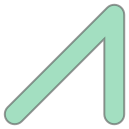

In [43]:
buffer_arc = shapely.wkt.loads(buffer_arc[0][0])
buffer_arc

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


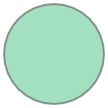

In [44]:
buffer_point = %sql SELECT ST_AsText(ST_Buffer(ST_GeomFromText('POINT(100 90)'), 50, 'quad_segs=8'));
buffer_point = shapely.wkt.loads(buffer_point[0][0])
buffer_point

Get the centroid of geometries. 

In [45]:
%%sql
SELECT name, ST_AsText(ST_Centroid(geom)) from uiuc_bus

 * postgresql://localhost:5432/postgisdemo
25 rows affected.


name,st_astext
MTD 5E Green Weekday - Daytime AM,POINT(-88.2257781326191 40.1104358037762)
MTD 12E Teal Weekday - Daytime,POINT(-88.2247878195216 40.1071841267018)
MTD 5W Green Express Weekday,POINT(-88.2306672609824 40.1069869996385)
MTD 22N Illini Weekday - Daytime,POINT(-88.2272455214682 40.1062045812129)
MTD 2U Red Weekday - Daytime,POINT(-88.2210811040126 40.1057991663561)
MTD 13N Silver Weekday - Daytime,POINT(-88.222888152858 40.1081345220597)
MTD 1N Yellow Weekday - Day,POINT(-88.2315466913782 40.1070662641163)
MTD 1S Yellow Weekday - Day,POINT(-88.2314435896292 40.1069605660486)
MTD 9A Brown Weekday - Daytime,POINT(-88.2304507371845 40.1055773548243)
MTD 2C Red Weekday - Daytime,POINT(-88.2210837352745 40.1058055282828)


Get all vertices of the geometry

In [46]:
%%sql MTD22N_Vertices <<
SELECT name, ST_AsText(ST_Points(geom)) from uiuc_bus where name like '%22N%'

 * postgresql://localhost:5432/postgisdemo
1 rows affected.
Returning data to local variable MTD22N_Vertices


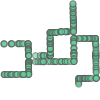

In [47]:
MTD22N_Vertices = shapely.wkt.loads(MTD22N_Vertices[0][1])
MTD22N_Vertices

### 3.3 Spatial Relationships

In [48]:
%%sql circles <<
SELECT ST_AsText(ST_Buffer(ST_GeomFromText('POINT(1 2)'), 10)) As smallc,
    ST_AsText(ST_Buffer(ST_GeomFromText('POINT(1 2)'), 20)) As bigc

 * postgresql://localhost:5432/postgisdemo
1 rows affected.
Returning data to local variable circles


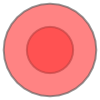

In [49]:
smallc = shapely.wkt.loads(circles[0][0])
bigc = shapely.wkt.loads(circles[0][1])
circles_ = shapely.geometry.MultiPolygon([smallc, bigc])
circles_

This is an example explaining some common spatial relationship functions of PostGIS. [Source](https://postgis.net/docs/ST_Contains.html)

In [50]:
%%sql
-- A circle within a circle
SELECT ST_Contains(smallc, bigc) As small_contains_big,
    ST_Contains(bigc,smallc) As bigcontainssmall,
    ST_Contains(bigc, ST_Union(smallc, bigc)) as big_contains_union,
    ST_Equals(bigc, ST_Union(smallc, bigc)) as big_is_union,
    ST_Covers(bigc, ST_ExteriorRing(bigc)) As big_covers_exterior,
    ST_Contains(bigc, ST_ExteriorRing(bigc)) As big_contains_exterior
FROM (SELECT ST_Buffer(ST_GeomFromText('POINT(1 2)'), 10) As smallc,
      ST_Buffer(ST_GeomFromText('POINT(1 2)'), 20) As bigc) As foo;

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


small_contains_big,bigcontainssmall,big_contains_union,big_is_union,big_covers_exterior,big_contains_exterior
False,True,True,True,True,False


[`ST_Distance`](https://postgis.net/docs/ST_Distance.html) finds distance between two geometric objects. 

Note: Measures in WGS84 (SRID:4326) are in angular units. We need to transform geometries to other spatial references with measures of length to get the correct distances between two geometries. A much simpler way is to convert geometries to `geography` type, and the distance function will return distances in meters. 

This is an example getting the distance between *Illini Union* and *Main Library* of UIUC campus in meters.

In [51]:
%%sql
WITH iu as
(
    SELECT geom::geography as g
    FROM uiuc_plg
    WHERE name like '%Illini%Union%'
    LIMIT 1
),
library as
(
    SELECT geom::geography as g
    FROM uiuc_plg
    WHERE name like '%Main%Lib%'
    LIMIT 1
)
SELECT ST_Distance(iu.g, library.g) from iu, library

 * postgresql://localhost:5432/postgisdemo
1 rows affected.


st_distance
423.09222859


[`ST_DWithin`](https://postgis.net/docs/ST_DWithin.html) returns true if the geometries are within the specified distance of one another.

With this function, we could find all the bus stops within 200 meters of *Main Library*, and find bus routes that serve those bus stops. 

In [52]:
%%sql 
SELECT name, ST_AsText(geom)
FROM uiuc_pts a, 
    (
        SELECT geom::geography as g
        FROM uiuc_plg
        WHERE name like '%Main%Lib%'
        LIMIT 1
    ) ml
WHERE ST_DWithin(ml.g, a.geom::geography, 200) and a.type = 'bus_stop'

 * postgresql://localhost:5432/postgisdemo
7 rows affected.


name,st_astext
Gregory at Library,POINT(-88.2286696 40.1040592)
Gregory at Library,POINT(-88.2289209 40.1042679)
Armory & Wright,POINT(-88.2287541 40.1056761)
Sixth & Armory,POINT(-88.2303615 40.1055564)
Sixth & Armory,POINT(-88.2302028 40.1052833)
Sixth & Gregory,POINT(-88.2303608 40.1042716)
Sixth & Gregory,POINT(-88.2301902 40.1040009)


In [53]:
%%sql
With mlib_bus_stop as (
    SELECT DISTINCT name, geom g
    FROM uiuc_pts a, (
            SELECT geom::geography as g
            FROM uiuc_plg
            WHERE name like '%Main%Lib%'
            LIMIT 1 ) ml
    WHERE ST_DWithin(ml.g, a.geom::geography, 200) and a.type = 'bus_stop'
)
SELECT DISTINCT a.name bus_stop, b.name route
FROM mlib_bus_stop a, uiuc_bus b
WHERE ST_DWithin(a.g, b.geom::geography, 15)

 * postgresql://localhost:5432/postgisdemo
40 rows affected.


bus_stop,route
Armory & Wright,MTD 13N Silver Weekday - Daytime
Armory & Wright,MTD 1N Yellow Weekday - Day
Armory & Wright,MTD 21 Raven Weekday - Daytime
Armory & Wright,MTD 22N Illini Weekday - Daytime
Armory & Wright,MTD 4E Blue - Weekday Daytime
Armory & Wright,MTD 8W Bronze Weekday - Daytime
Armory & Wright,MTD 9B Brown Weekday - Daytime
Gregory at Library,MTD 10E Gold Weekday - Daytime
Gregory at Library,MTD 10W Gold Weekday - Daytime
Gregory at Library,MTD 13N Silver Weekday - Daytime


The inherent table `geometry_columns` keeps track of every column of `geometry` type in the database. 

In [54]:
%sql select * from geometry_columns

 * postgresql://localhost:5432/postgisdemo
4 rows affected.


f_table_catalog,f_table_schema,f_table_name,f_geometry_column,coord_dimension,srid,type
postgisdemo,public,uiuc_bus,geom,2,4326,MULTILINESTRING
postgisdemo,public,uiuc_plg,geom,2,4326,GEOMETRY
postgisdemo,public,gis_example,geom,2,0,GEOMETRY
postgisdemo,public,uiuc_pts,geom,2,4326,POINT


## 4. Sptial Indexing

Indexes are what make using a spatial database for large data sets possible. Without indexing, any search for a feature would require a "sequential scan" of every record in the database. Indexing speeds up searching by organizing the data into a search tree which can be quickly traversed to find a particular record. PostgreSQL supports three kinds of indexes by default: B-Tree indexes, SP-GiST and GiST indexes.

We can see all the indices that are created on our database. 

In [55]:
%sql SELECT * FROM pg_indexes WHERE schemaname = 'public'

 * postgresql://localhost:5432/postgisdemo
5 rows affected.


schemaname,tablename,indexname,tablespace,indexdef
public,uiuc_bus,uiuc_bus_pkey,None,CREATE UNIQUE INDEX uiuc_bus_pkey ON public.uiuc_bus USING btree (id)
public,gis_example,gis_example_pkey,None,CREATE UNIQUE INDEX gis_example_pkey ON public.gis_example USING btree (id)
public,spatial_ref_sys,spatial_ref_sys_pkey,None,CREATE UNIQUE INDEX spatial_ref_sys_pkey ON public.spatial_ref_sys USING btree (srid)
public,uiuc_pts,uiuc_pts_pkey,None,CREATE UNIQUE INDEX uiuc_pts_pkey ON public.uiuc_pts USING btree (id)
public,uiuc_plg,uiuc_plg_pkey,None,CREATE UNIQUE INDEX uiuc_plg_pkey ON public.uiuc_plg USING btree (id)


However, we find out that the spatial index is not automatically generated. 

In this section, we will see how spatial index will help accelerate our spatial queries. 

### 4.1 No sptial index

In [56]:
%sql DROP INDEX IF EXISTS pts_idx;

 * postgresql://localhost:5432/postgisdemo
Done.


[]

In [57]:
%%time
%%sql bus_res <<
SELECT DISTINCT a.name bus_stop, b.name route
FROM uiuc_pts a, uiuc_bus b
WHERE ST_DWithin(a.geog, b.geog, 15)

 * postgresql://localhost:5432/postgisdemo
0 rows affected.
Returning data to local variable bus_res
CPU times: user 2.7 ms, sys: 1.34 ms, total: 4.04 ms
Wall time: 3.9 ms


### 4.2 GiST (Generalized Search Tree) Indexes

In [58]:
%%sql
DROP INDEX IF EXISTS pts_idx;
CREATE INDEX pts_idx_spgist ON uiuc_pts USING GIST(geog);

 * postgresql://localhost:5432/postgisdemo
Done.
Done.


[]

In [59]:
%%time
%%sql bus_res <<
SELECT DISTINCT a.name bus_stop, b.name route
FROM uiuc_pts a, uiuc_bus b
WHERE ST_DWithin(a.geog, b.geog, 15)

 * postgresql://localhost:5432/postgisdemo
0 rows affected.
Returning data to local variable bus_res
CPU times: user 2.54 ms, sys: 1.32 ms, total: 3.86 ms
Wall time: 3.1 ms


### 4.3 BRIN (Block Range Index) Indexes

In [60]:
%%sql
DROP INDEX IF EXISTS pts_idx;
CREATE INDEX pts_idx ON uiuc_pts USING BRIN(geog);

 * postgresql://localhost:5432/postgisdemo
Done.
Done.


[]

In [61]:
%%time
%%sql bus_res <<
SELECT DISTINCT a.name bus_stop, b.name route
FROM uiuc_pts a, uiuc_bus b
WHERE ST_DWithin(a.geog, b.geog, 15)

 * postgresql://localhost:5432/postgisdemo
0 rows affected.
Returning data to local variable bus_res
CPU times: user 2.43 ms, sys: 1.42 ms, total: 3.85 ms
Wall time: 2.98 ms


### 4.4 SP-GiST (Space-Partitioned Generalized Search Tree) Indexes

In [62]:
%%sql
DROP INDEX IF EXISTS pts_idx;
CREATE INDEX pts_idx ON uiuc_pts USING SPGIST(geog);

 * postgresql://localhost:5432/postgisdemo
Done.
Done.


[]

In [63]:
%%time
%%sql bus_res <<
SELECT DISTINCT a.name bus_stop, b.name route
FROM uiuc_pts a, uiuc_bus b
WHERE ST_DWithin(a.geog, b.geog, 15)

 * postgresql://localhost:5432/postgisdemo
0 rows affected.
Returning data to local variable bus_res
CPU times: user 2.97 ms, sys: 1.46 ms, total: 4.43 ms
Wall time: 3.51 ms
